##### Notebook where I am experimenting with an autoencoder for image compression (PyTorch)

Using FashionMNIST dataset

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
from torchvision import datasets
import torchvision.transforms as transforms
from torchsummary import summary
import torch.nn.functional as F

In [2]:

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.has_mps else "cpu")
device

device(type='mps')

In [5]:
# Loadin the dataset Fashion MNIST
train_dataset = datasets.FashionMNIST(root='../../../pytorch_learning/data',
train=True, 
transform=transforms.ToTensor(), download=False)

test_dataset = datasets.FashionMNIST(root='../../../pytorch_learning/data',
train=False,
transform=transforms.ToTensor(), download=False)


In [6]:
# Data loader

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
batch_size=100, shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
batch_size=100, shuffle=False)

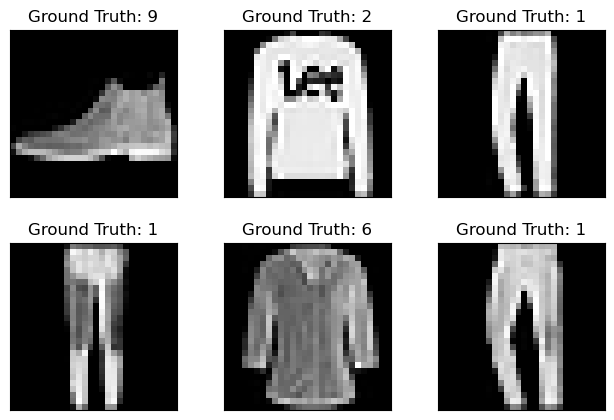

In [8]:
# taking a look at few images
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

# Plot
fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()


In [10]:
# image dimensions
example_data[0].shape

torch.Size([1, 28, 28])

In [9]:
# groud truth to labels
ground_truth_labels = {0: 'T-shirt/top',
        1: 'Trouser', 2: 'Pullover', 
        3: 'Dress', 4: 'Coat', 5: 'Sandal', 
        6: 'Shirt', 7: 'Sneaker', 8: 'Bag',
         9: 'Ankle boot'}

In [12]:

# Autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(True), # inplace=True
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12))
        self.decoder = nn.Sequential(
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28*28),
            nn.Tanh())
        
    def forward(self, x):
        x = self.encoder(x) # encoding
        x = self.decoder(x) # decoding
        return x

In [13]:

# model
model = Autoencoder().to(device)
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=64, out_features=12, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=64, out_features=128, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)

In [15]:
# number of parameters being trained
sum(p.numel() for p in model.parameters() if p.requires_grad)

219804

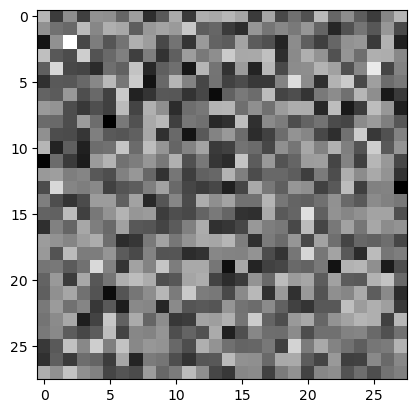

In [16]:
# quick eval on a random sample
model.eval()
with torch.no_grad():
    x = example_data[0].view(-1, 28*28).to(device)
    out = model(x)
    out_img = out.view(28,28).cpu().numpy()
    plt.imshow(out_img, cmap='gray')
    plt.show()

We use reconstruction loss to train the autoencoder

In [17]:
# Train function - one epoch

def train(model, train_loader, optimizer, criterion, epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader): # notice that we are not using the labels
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data) # reconstruction loss
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    print('====> Epoch: {} Average reconstruction loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))
    return train_loss / len(train_loader.dataset)

# Test function - one epoch

def test(model, test_loader, criterion, epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader): # not using labels
            data = data.view(-1, 28*28).to(device)
            output = model(data)
            test_loss += criterion(output, data).item() # reconstruction loss
    test_loss /= len(test_loader.dataset)
    print('====> Test set reconstruction loss: {:.4f}'.format(test_loss))
    return test_loss

In [18]:
# Training the model

# Hyperparameters
num_epochs = 3
learning_rate = 1e-3

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

# Train and test
train_loss = []
test_loss = []

for epoch in range(1, num_epochs + 1):
    train_loss.append(train(model, train_loader, optimizer, criterion, epoch))
    test_loss.append(test(model, test_loader, criterion, epoch))

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.202077
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.046832
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.036203
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.027354
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.027711
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.023267
====> Epoch: 1 Average reconstruction loss: 0.0004
====> Test set reconstruction loss: 0.0002
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.022411
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.023424
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.022814
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.022730
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.020629
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.019347
====> Epoch: 2 Average reconstruction loss: 0.0002
====> Test set reconstruction loss: 0.0002
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.021684
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.019408
Train Epoch: 3 [20000/60000 (33%)]	Loss: 0.021456
Train Epoch: 3 [30000/60000 (50%)]	Loss: 0.019556
Train Epoch: 3 [40000/60000

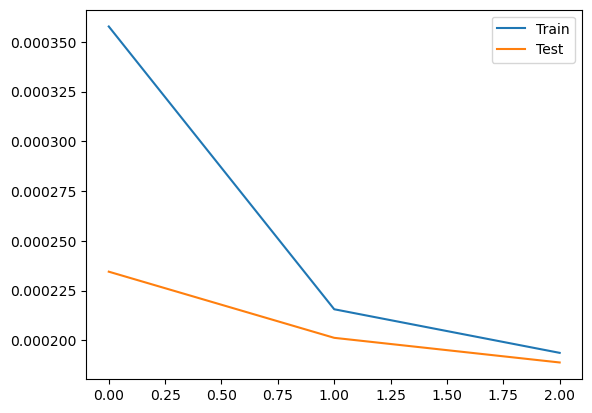

In [33]:
# Plot the loss
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.legend()

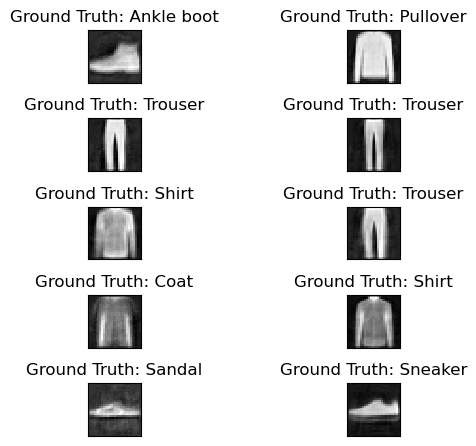

In [28]:
# lets see 10 reconstructed images
model.eval()
with torch.no_grad():
    x = example_data[0:10].view(-1, 28*28).to(device)
    out = model(x)
    out_img = out.view(-1, 28,28).cpu().numpy()
    fig = plt.figure()
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.tight_layout()
        plt.imshow(out_img[i], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(ground_truth_labels[example_targets[i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

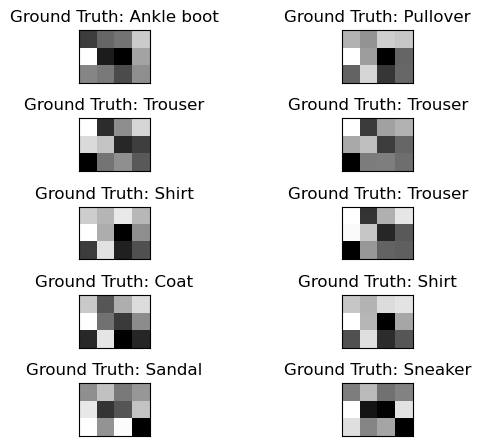

In [29]:
# Autoencoder can be used for dimensionality reduction
# lets see the output of the encoder
# 28*28 -> 128 -> 64 -> 12
model.eval()
with torch.no_grad():
    x = example_data[0:10].view(-1, 28*28).to(device)
    out = model.encoder(x)
    out_img = out.view(-1, 3,4).cpu().numpy()
    fig = plt.figure()
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.tight_layout()
        plt.imshow(out_img[i], cmap='gray', interpolation='none')
        plt.title("Ground Truth: {}".format(ground_truth_labels[example_targets[i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

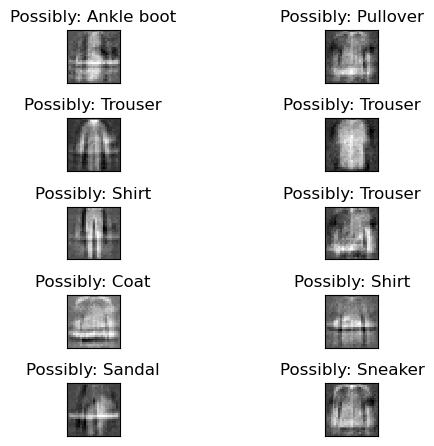

In [32]:
###### Generate few images from random noise ######

# Generate random noise
noise = torch.randn(10, 12).to(device)

# Generate images from noise
model.eval()
with torch.no_grad():
    out = model.decoder(noise)
    out_img = out.view(-1, 28,28).cpu().numpy()
    fig = plt.figure()
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.tight_layout()
        plt.imshow(out_img[i], cmap='gray', interpolation='none')
        plt.title("Possibly: {}".format(ground_truth_labels[example_targets[i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

## VAE - Variational Autoencoder

##### Let's try to use a VAE to generate new images

A good resource : https://towardsdatascience.com/intuitively-understanding-variational-autoencoders-1bfe67eb5daf

In [34]:
# Trying VAE now on Fashion MNIST

# VAE class

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(28*28, 400)
        self.fc21 = nn.Linear(400, 20)
        self.fc22 = nn.Linear(400, 20)
        self.fc3 = nn.Linear(20, 400)
        self.fc4 = nn.Linear(400, 28*28)
        
    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)
    
    def reparameterize(self, mu, logvar):
        """ 
        Reparameterization trick to sample from N(mu, std) from
        N(0,1).

        z = mu + std*eps
        eps ~ N(0,1)
        logvar = log(std^2)
        """
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std # samples from N(mu, std)
    
    def decode(self, z):
        """ 
        z ~ N(0,1)
        """
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3)) # sigmoid is used because we are using BCE loss
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar) # samples from N(mu, std)
        return self.decode(z), mu, logvar # sample is fed to decoder

In [45]:
# lets visualize the model
summary(VAE(), (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 400]         314,000
            Linear-2                   [-1, 20]           8,020
            Linear-3                   [-1, 20]           8,020
            Linear-4                  [-1, 400]           8,400
            Linear-5                  [-1, 784]         314,384
Total params: 652,824
Trainable params: 652,824
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.49
Estimated Total Size (MB): 2.51
----------------------------------------------------------------


In [44]:
model = VAE().to(device)

In [47]:

# Loss function

def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum') # reconstruction loss
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) # KL divergence loss
    return BCE + KLD

In [50]:
# Training the model

# Hyperparameters
num_epochs = 10
learning_rate = 1e-3

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train and test without the previous functions
train_loss = []
test_loss = []

for epoch in range(1, num_epochs + 1):
    model.train()
    train_loss_epoch = 0
    for i, (data, _) in enumerate(train_loader): # not using labels
        data = data.view(-1, 28*28).to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data) # recon_batch is the output of the decoder
        loss = loss_function(recon_batch, data, mu, logvar) # loss is the sum of BCE and KLD
        loss.backward()
        train_loss_epoch += loss.item()
        optimizer.step()
    train_loss_epoch /= len(train_loader.dataset)
    train_loss.append(train_loss_epoch)
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss_epoch))
    
    model.eval()
    test_loss_epoch = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader): # not using labels
            data = data.view(-1, 28*28).to(device)
            recon_batch, mu, logvar = model(data)
            test_loss_epoch += loss_function(recon_batch, data, mu, logvar).item()
    test_loss_epoch /= len(test_loader.dataset)
    test_loss.append(test_loss_epoch)
    print('====> Test set loss: {:.4f}'.format(test_loss_epoch))

====> Epoch: 1 Average loss: 246.5640
====> Test set loss: 247.2650
====> Epoch: 2 Average loss: 245.0381
====> Test set loss: 246.1559
====> Epoch: 3 Average loss: 244.0513
====> Test set loss: 245.7557
====> Epoch: 4 Average loss: 243.3987
====> Test set loss: 245.0076
====> Epoch: 5 Average loss: 242.8835
====> Test set loss: 244.3062
====> Epoch: 6 Average loss: 242.4569
====> Test set loss: 243.9513
====> Epoch: 7 Average loss: 242.1035
====> Test set loss: 243.8750
====> Epoch: 8 Average loss: 241.8194
====> Test set loss: 243.7474
====> Epoch: 9 Average loss: 241.5468
====> Test set loss: 243.1073
====> Epoch: 10 Average loss: 241.3619
====> Test set loss: 242.9886


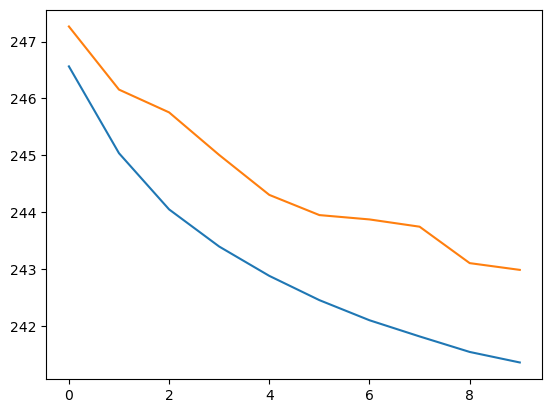

In [51]:
# Plot the loss
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')

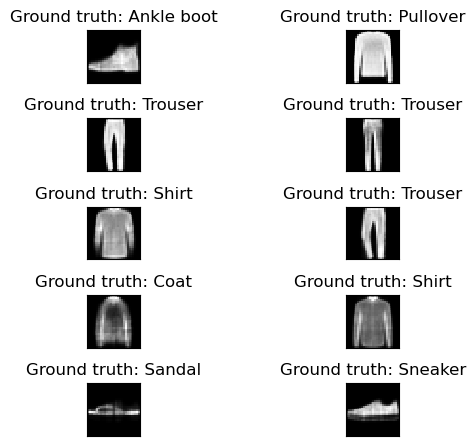

In [53]:
# lets see 10 reconstructed images
model.eval()
with torch.no_grad():
    x = example_data[0:10].view(-1, 28*28).to(device)
    out, _, _ = model(x)
    out_img = out.view(-1, 28,28).cpu().numpy()
    fig = plt.figure()
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.tight_layout()
        plt.imshow(out_img[i], cmap='gray', interpolation='none')
        plt.title("Ground truth: {}".format(ground_truth_labels[example_targets[i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.show()

> Its performing pretty well.

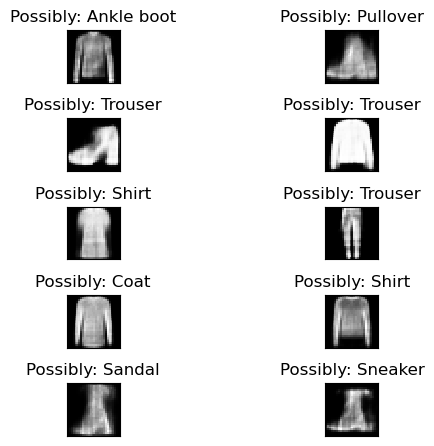

In [56]:
# Generate few images from random noise
noise = torch.randn(10, 20).to(device)

model.eval()
with torch.no_grad():
    out = model.decode(noise)
    out_img = out.view(-1, 28,28).cpu().numpy()
    fig = plt.figure()
    for i in range(10):
        plt.subplot(5,2,i+1)
        plt.tight_layout()
        plt.imshow(out_img[i], cmap='gray', interpolation='none')
        plt.title("Possibly: {}".format(ground_truth_labels[example_targets[i].item()]))
        plt.xticks([])
        plt.yticks([])
    plt.show()